# Test du Laplacien

pygame 2.4.0 (SDL 2.26.5, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.11


[I 04/19/24 11:29:17.919 7808] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


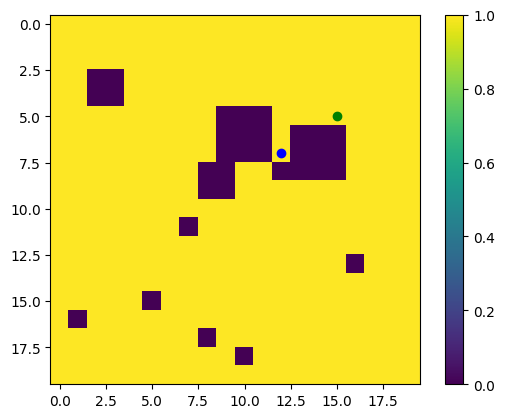

In [2]:
import phi.flow as phiflow
from snake_ai.envs import RandomObstaclesEnv
import numpy as np
import matplotlib.pyplot as plt

env = RandomObstaclesEnv(pixel=1, nb_obs=10, max_obs_size=3)
env.reset()
plt.imshow(env._free_position_mask)
plt.plot(env.goal.x, env.goal.y, 'go')
plt.plot(env.agent.position.x, env.agent.position.y, 'bo')
plt.colorbar()

<class 'phi.field._point_cloud.PointCloud'>


<Figure size 1200x500 with 1 Axes>

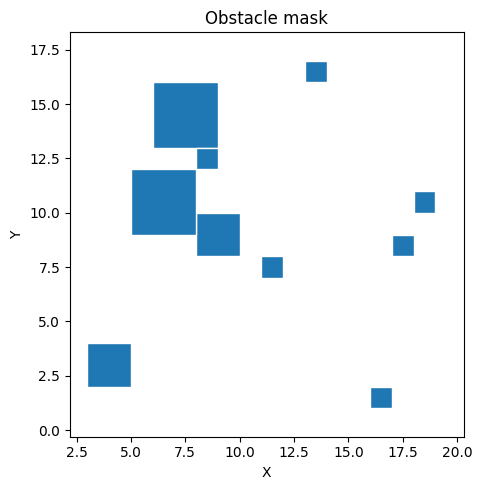

In [3]:
def convert_obstacles_to_geometry(obstacles):
    # Handle the case where there is only one obstacle
    return [
        phiflow.Box(
            x=(obs.left, obs.right),
            y=(obs.top, obs.bottom),
        )
        for obs in obstacles
    ]
obstacle_list = convert_obstacles_to_geometry(env.obstacles)
obstacle_mask = phiflow.mask(phiflow.union(obstacle_list))
print(type(obstacle_mask))
phiflow.vis.plot(phiflow.union(obstacle_list), title='Obstacle mask')
# grid_space = 100
# center = grid_space // 2
# one_tenth = grid_space // 10

# b = np.zeros((grid_space, grid_space))
# # b[0, :] = 100
# # b[-1, :] = 100
# # b[:, 0] = 100
# # b[:, -1] = 100
# # b[left:-left, left:-left] = 100
# b[10:20, 10:20] = 10
# b[center:center+one_tenth, center:center+one_tenth] = 1
# b = phiflow.tensor(b, phiflow.spatial('x,y'))
# print(b)
# bounds = phiflow.Box(x=1, y=1)
# centered_grid = phiflow.CenteredGrid(b, extrapolation=10, bounds=bounds)
# phiflow.vis.plot(centered_grid)

Box(x=(0, 20), y=(0, 20))
Box(x=(15, 16), y=(5, 6))
PointCloud[()]


<Figure size 1200x500 with 2 Axes>

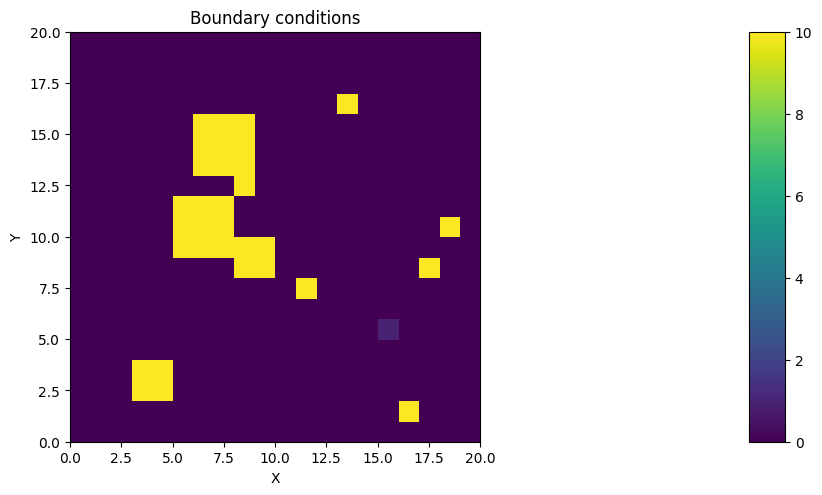

In [4]:
bounds = phiflow.Box(x=env.width, y=env.height)

goal = phiflow.Box(x=(env.goal.left, env.goal.right), y=(env.goal.top, env.goal.bottom))
print(bounds)
print(goal)
print(phiflow.mask(goal))
resolution = 3

boundary_conditions = phiflow.CenteredGrid(0, bounds=bounds, extrapolation=10, resolution=phiflow.spatial(x=env.width * resolution, y= env.height * resolution))
boundary_conditions = phiflow.field.where(phiflow.mask(goal), 1, boundary_conditions)
boundary_conditions = phiflow.field.where(obstacle_mask, 10, boundary_conditions)
phiflow.vis.plot(boundary_conditions, title='Boundary conditions')


<Figure size 1200x500 with 2 Axes>

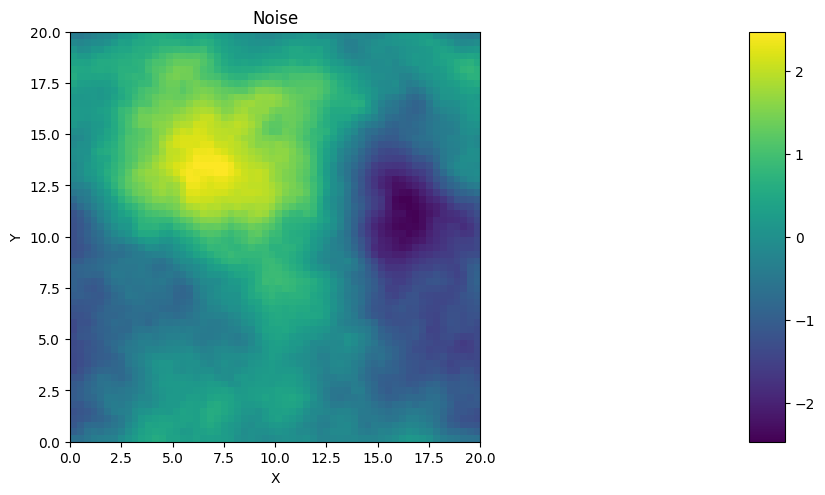

In [5]:
init_value = phiflow.CenteredGrid(phiflow.Noise(), extrapolation=10, bounds=bounds, resolution=boundary_conditions.resolution)
phiflow.vis.plot(init_value, title='Noise')

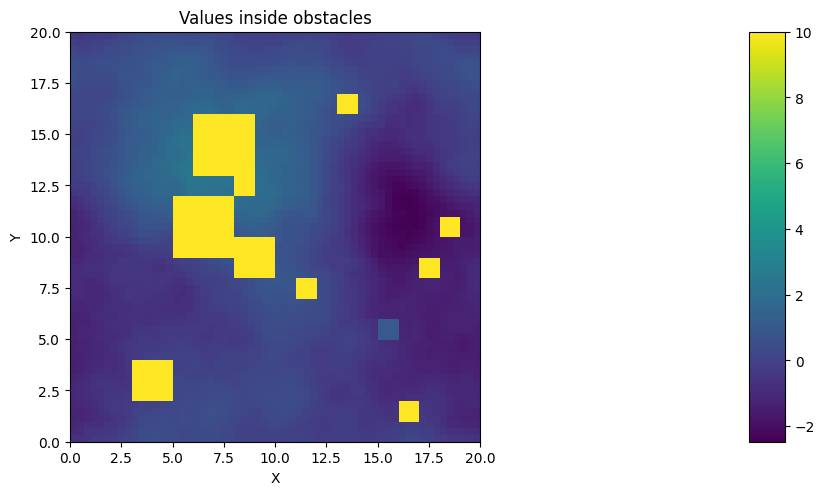

In [6]:
masked_value = phiflow.field.where(boundary_conditions, boundary_conditions, init_value)
phiflow.vis.plot(masked_value, title='Values inside obstacles')
solver = phiflow.Solve('auto', rel_tol=1e-5, x0=masked_value)

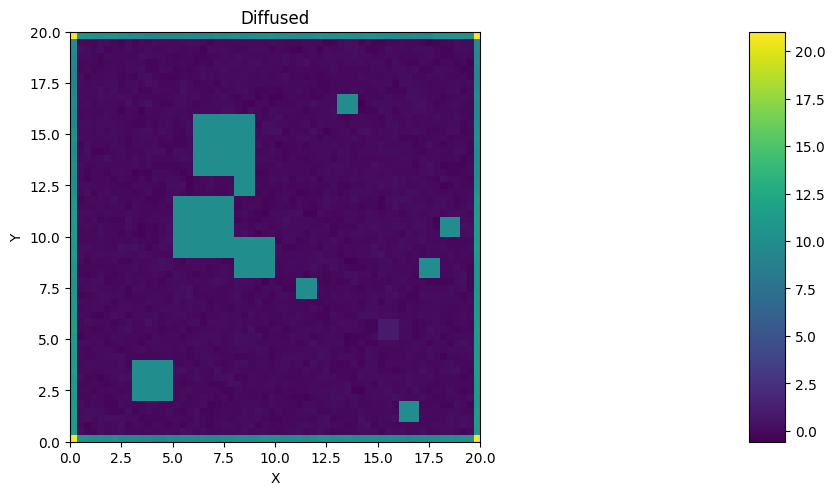

In [7]:
from functools import partial

def laplace_with_boundaries(grid : phiflow.CenteredGrid, obstacle_mask : phiflow.CenteredGrid, goal : phiflow.CenteredGrid):
    diffused = phiflow.field.laplace(grid, weights=grid.dx**2)
    diffused = phiflow.field.where(obstacle_mask, 10, diffused)
    return phiflow.field.where(goal, 1, diffused)

goal_mask = phiflow.mask(goal)
diffused = laplace_with_boundaries(init_value, obstacle_mask, goal_mask)
phiflow.vis.plot(diffused, title='Diffused')
speedup_laplace = phiflow.jit_compile_linear(phiflow.field.laplace)

<Figure size 1200x500 with 2 Axes>

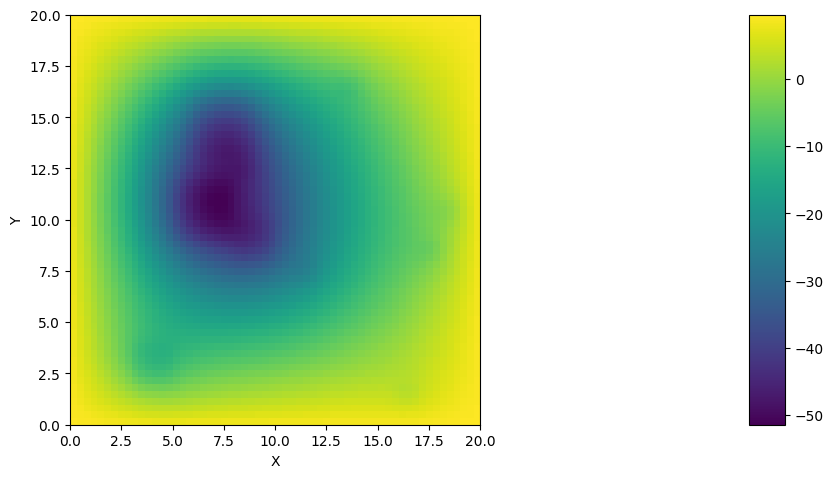

In [8]:
solution = phiflow.solve_linear(phiflow.field.laplace, boundary_conditions, solve=solver)
phiflow.vis.plot(solution)

<Figure size 1200x500 with 2 Axes>

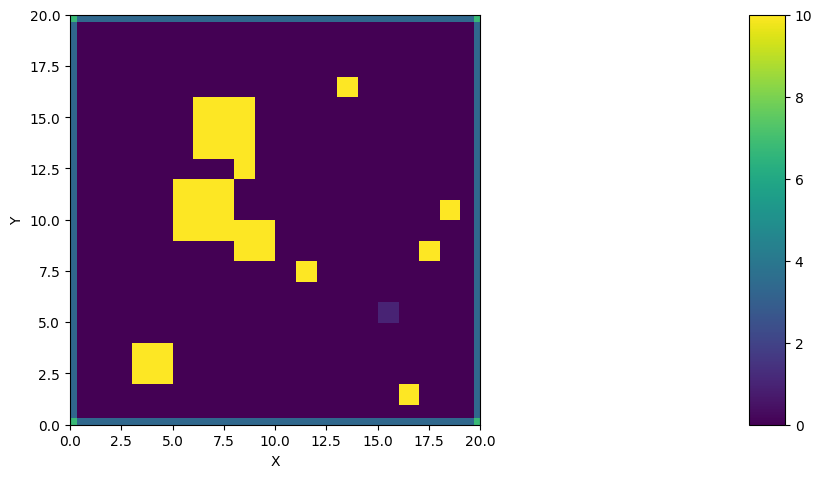

In [9]:
phiflow.vis.plot([phiflow.field.laplace(solution)])

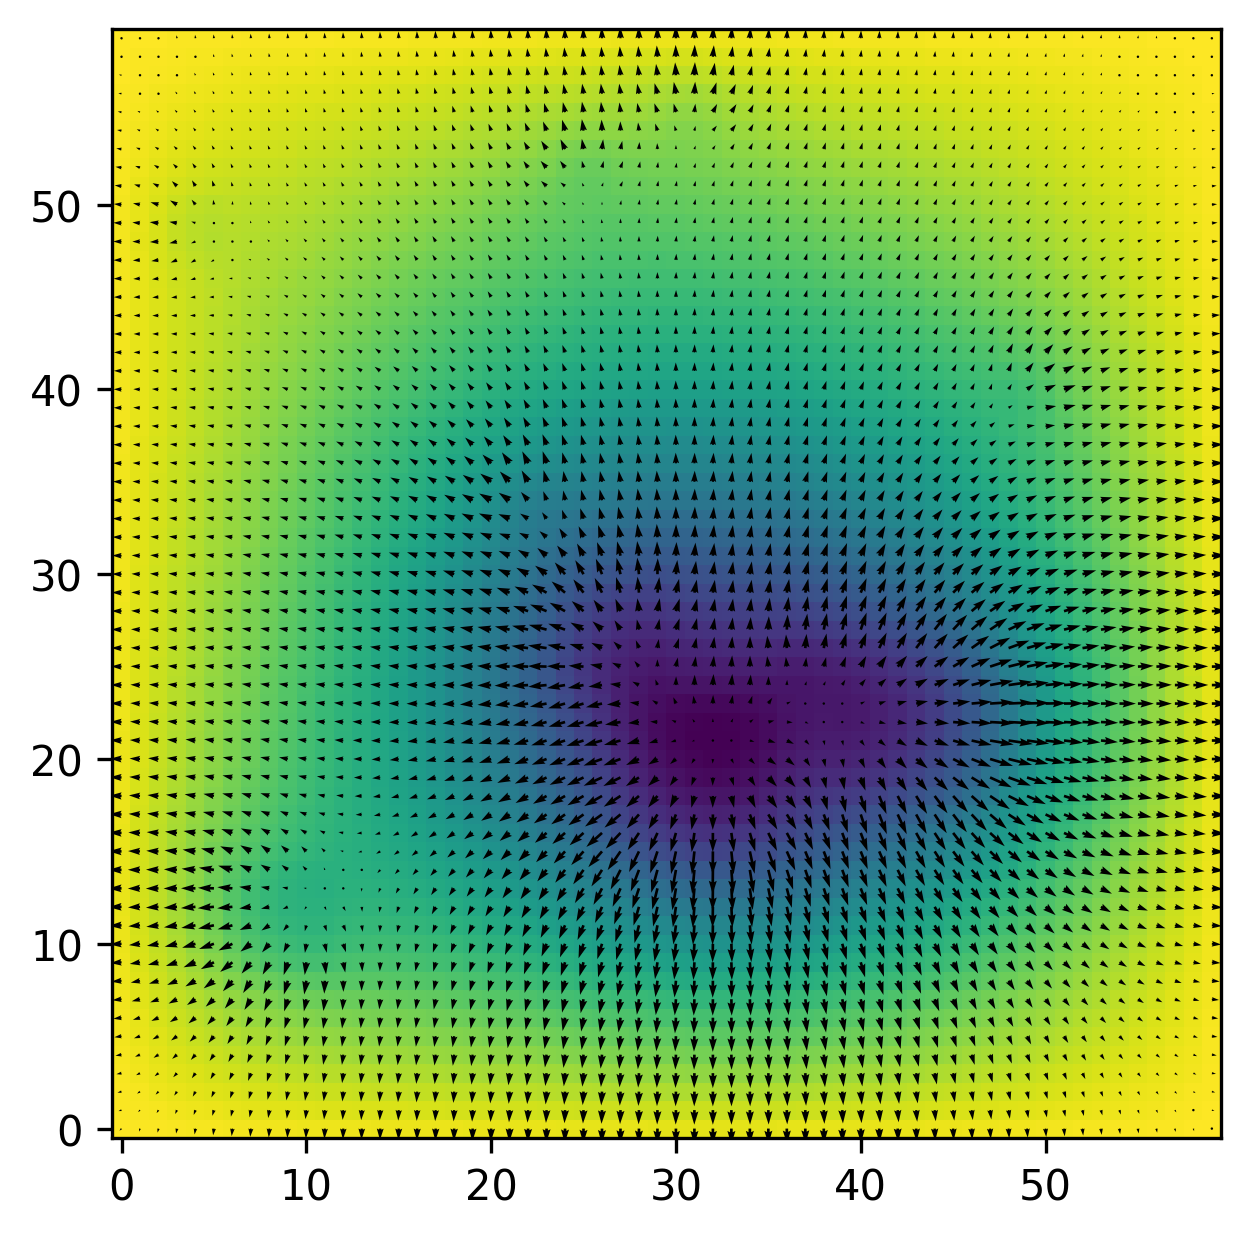

In [10]:
grad = phiflow.field.spatial_gradient(solution)
dx, dy = grad.values.numpy('vector,x,y')
sol = solution.values.numpy('x,y')
plt.figure(dpi=300)
plt.imshow(sol, origin='lower')
plt.quiver(dy, dx)

/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/phi/math/backend/_backend.py:1468: RuntimeWarning: overflow encountered in scalar add
  return a + b


<Figure size 1200x500 with 2 Axes>

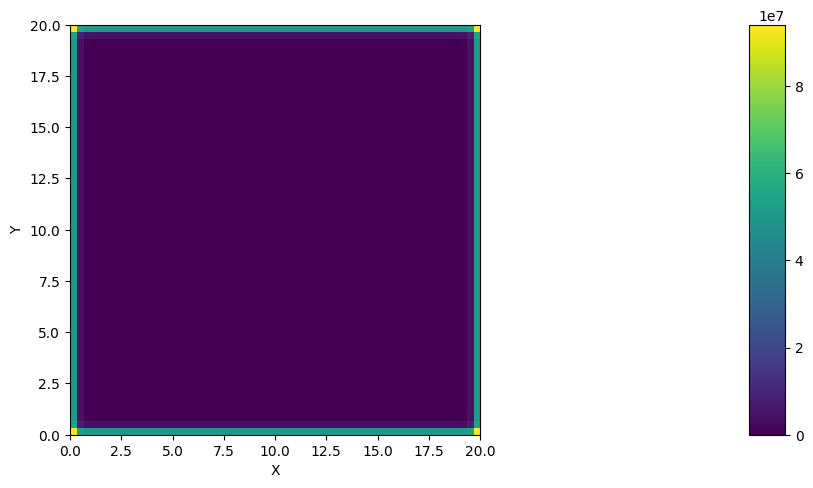

In [13]:
def jacobi(grid, boundary_conditions, goal, iterations=10):
    bound = max(boundary_conditions.dx)**2 / 4
    for _ in range(iterations):
        grid += bound * laplace_with_boundaries(grid, boundary_conditions, goal)
    return grid

solution = jacobi(masked_value, boundary_conditions, goal_mask, iterations=30)
phiflow.vis.plot(solution)

In [14]:
def multigrid(grid, boundary_conditions, iterations=10):
    bound = max(boundary_conditions.dx)**2 / 4
    for _ in range(iterations):
        grid += bound * laplace_with_boundaries(grid, boundary_conditions)
    return grid

# Integration des codes de scipy

In [15]:
from snake_ai.diffsim.finite_difference import create_laplacian_matrix_2d
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

bc_mat = boundary_conditions.values.numpy('x,y')
init_value = init_value.values
# laplacian_matrix = create_laplacian_matrix_2d(*bc_mat.shape, *boundary_conditions.dx.numpy())
laplacian_matrix = splinalg.LaplacianNd(bc_mat.shape)
laplacian_matrix =  boundary_conditions.dx.numpy()[0] * laplacian_matrix.tosparse()
bc_mat[0,:] = 10
bc_mat[-1,:] = 10
bc_mat[:,0] = 10
bc_mat[:,-1] = 10

rhs = bc_mat.flatten() 
indices = np.nonzero(rhs)
laplacian_matrix[indices] = 0
laplacian_matrix[indices, indices] = 1
laplacian_matrix.eliminate_zeros()

AttributeError: module 'scipy.sparse.linalg' has no attribute 'LaplacianNd'

In [16]:
solution : np.ndarray = splinalg.spsolve(laplacian_matrix, rhs)
solution = solution.reshape(bc_mat.shape)

NameError: name 'laplacian_matrix' is not defined

In [ ]:
plt.figure(dpi=300)
log_sol = np.log(solution)
plt.imshow(solution, origin='lower')
plt.colorbar()
dy, dx = np.gradient(log_sol)
plt.quiver(-dx, -dy, scale=1)

NameError: name 'plt' is not defined